# Detecting Credit Card Transaction Fraud using Machine Learning

Consumers lost over $6 billion to online credity card fraud in 2021 as per the [Wall Street Journal](https://www.wsj.com/articles/borrower-beware-credit-card-fraud-attempts-rise-during-the-coronavirus-crisis-11590571800). Therefore, there is a need to develop tools that can alert customers and banks when such type of fradulent activity is attempted as a prevetitive measure. Treating fraudulent and non-fradulent transactions as distinct classes, this problem can be boiled down to a classification task through machine learning.

Another problem that can be foreseen while developing machine learning based tools to prevent fradulent transactions is that credit card transaction data contains highly confidential personal information. Therefore, access to credit card transaction data is highly restricted.

With these motivations, this notebook showcases a two step case study illustrating the power of machine learning in detecting credit card transaction fraud. In the first step, synthetic data using [Sparkov Data Generator](https://github.com/namebrandon/Sparkov_Data_Generation) was generated for 500 customers from 1-1-2019 to 12-31-2021 for over 1.5 million unique transactions. The generated data resembles realistic credit card transaction data and can be used for training machine learning models. The feature engineering and data augmentation techniques such as SMOTE can be applied to improve model performance on real life data for classification of fraudulent from non-fraudulent transactions.

In [1]:
# Import libraries
import pandas as pd
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from collections import Counter
from imblearn.over_sampling import SMOTE

E:\anaconda_installer\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Generation and Ingestion

The data was generated using [Sparkov Data Generator](https://github.com/namebrandon/Sparkov_Data_Generation) for 500 unique customer profiles and between dates 1-1-2019 and 12-31-2021. The following command was used to generate synthetic data resulting in over 1.5 million unique transactions:
- python datagen.py -n 500 -o ".\data\transactions" 1-1-2019 12-31-2021

In [2]:
# Get CSV files list from a folder
csv_files = glob.glob('C:/Sparkov_Data_Generation-master/data/transactions/*.csv')
# Create a list of CSV files
df_list = (pd.read_csv(file, sep = '|') for file in csv_files)
# Concatenate all CSV files
df = pd.concat(df_list, ignore_index=True)

In [3]:
len(df)

1529862

In [4]:
df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,186-89-2713,3506537947383471,Stephanie,Lee,F,4688 Burch Viaduct Apt. 924,Windsor,IL,61957,39.4302,...,6b024ce35dcc06e8d0cc28c3f2fd51af,2021-08-06,01:25:43,1628193343,grocery_pos,14.03,1,"Murray-Smitham,",40.037349,-87.855038
1,186-89-2713,3506537947383471,Stephanie,Lee,F,4688 Burch Viaduct Apt. 924,Windsor,IL,61957,39.4302,...,1128f147c155033ab540cd40428d6649,2021-08-06,00:56:36,1628191596,shopping_net,303.33,1,"Ruecker, Beer and Collier",39.961071,-88.489646
2,186-89-2713,3506537947383471,Stephanie,Lee,F,4688 Burch Viaduct Apt. 924,Windsor,IL,61957,39.4302,...,5574cfe72f4c3aa3c89aefc99028e0cd,2021-08-06,02:54:27,1628198667,shopping_net,862.15,1,"Gleason-Macejkovic,",39.733953,-87.967541
3,186-89-2713,3506537947383471,Stephanie,Lee,F,4688 Burch Viaduct Apt. 924,Windsor,IL,61957,39.4302,...,202c79e6b473cb8a508799c94a629d5c,2021-08-06,03:48:51,1628201931,gas_transport,1179.11,1,"Corwin-Collins,",39.010562,-88.50314
4,186-89-2713,3506537947383471,Stephanie,Lee,F,4688 Burch Viaduct Apt. 924,Windsor,IL,61957,39.4302,...,9ce8b478409bad7c762d65c9595c9fd4,2021-08-06,00:49:27,1628191167,misc_pos,871.76,1,"Block Group,",40.273711,-89.112075


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529862 entries, 0 to 1529861
Data columns (total 26 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   ssn         1529862 non-null  object
 1   cc_num      1529862 non-null  object
 2   first       1529862 non-null  object
 3   last        1529862 non-null  object
 4   gender      1529862 non-null  object
 5   street      1529862 non-null  object
 6   city        1529862 non-null  object
 7   state       1529862 non-null  object
 8   zip         1529862 non-null  object
 9   lat         1529862 non-null  object
 10  long        1529862 non-null  object
 11  city_pop    1529862 non-null  object
 12  job         1529862 non-null  object
 13  dob         1529862 non-null  object
 14  acct_num    1529862 non-null  object
 15  profile     1529862 non-null  object
 16  trans_num   1529362 non-null  object
 17  trans_date  1529362 non-null  object
 18  trans_time  1529362 non-null  object
 19  

In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

ssn           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
acct_num      0
profile       0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

In [8]:
#Calculate percentage of fraud transactions in each spending category
fraud_txn = (df.query("is_fraud == 1")['category']
             .value_counts(normalize = False)
             .to_frame()
             .reset_index())
not_fraud_txn = (df.query("is_fraud == 0")['category']
                 .value_counts(normalize = False)
                 .to_frame()
                 .reset_index())
fraud_txn.columns = ['category','fraud_txn']
not_fraud_txn.columns = ['category','not_fraud_txn']
category_txn =  fraud_txn.merge(not_fraud_txn, on = 'category')
category_txn['percentage_fraud'] = (category_txn['fraud_txn']/category_txn['not_fraud_txn'])*100

In [9]:
pio.renderers
pio.renderers.default = "svg"

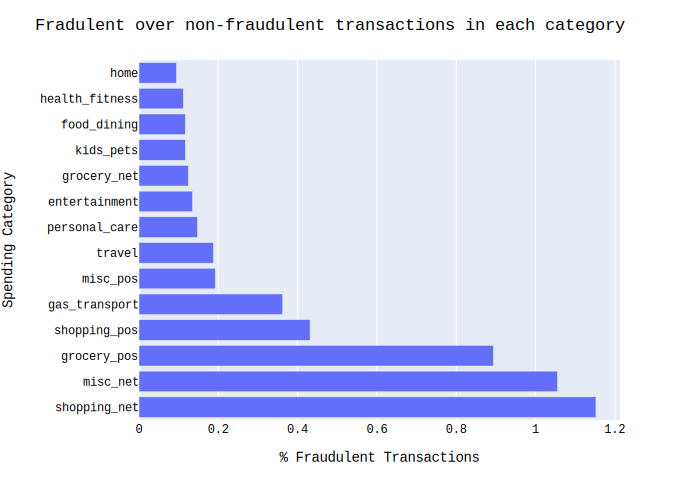

In [10]:
#Plot percentage of fraud transactions in each spending categor
category_txn_sorted = category_txn.sort_values('percentage_fraud', ascending = False)
fig = px.bar(category_txn_sorted, x='percentage_fraud', y='category', orientation='h')

fig.update_layout(
    title="Fradulent over non-fraudulent transactions in each category",
    xaxis_title="% Fraudulent Transactions",
    yaxis_title="Spending Category",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="black"
    )
)

fig.show()

It can be seen from the plot that a very small percentage of the transactions are fraudulent. This highlights a severe class imbalance where one of the classes (fraudulent transactions) constitutes a little over 1% of the total dataset. Therefore, there is a need for feature engineering and data augmentation methods for improving model performance.

# Feature Engineering

Typically, fraudulent transactions will occur when an individual is not actively monitoring their accounts. Accordingly, it makes sense to explore the time at which fraudulent and non fraudulent transactions occur. Furthermore, it's also important to visualize the dollar value of each of the fraudulent transaction as compared to the non-fraudulent transactions. The visualizations can then be used to define new features that can improve model performance when classifying fraudulent from non fraudulent transactions. 

In [11]:
df["trans_time"]= pd.to_datetime(df["trans_time"])

In [12]:
df['hour'] = df.trans_time.dt.hour

In [27]:
pio.renderers
pio.renderers.default = "svg"

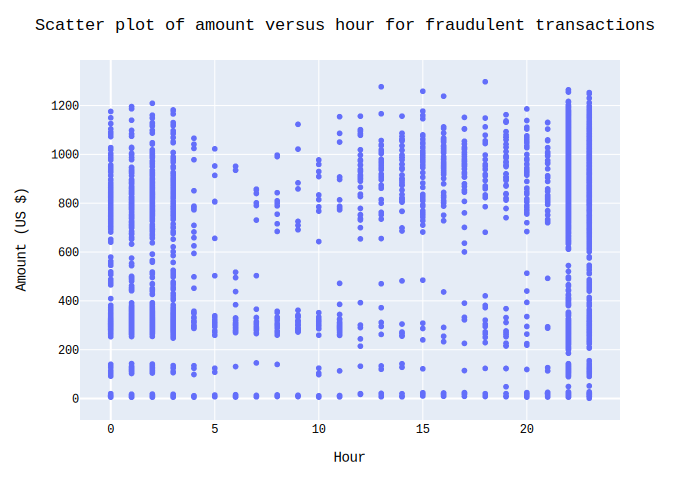

In [28]:
#sns.scatterplot(data=df, x="hour", y="amt", hue="is_fraud")
fraud_txn2 = (df.query("is_fraud == 1"))
fig = px.scatter(fraud_txn2, x='hour', y='amt')

fig.update_layout(
    title="Scatter plot of amount versus hour for fraudulent transactions",
    xaxis_title="Hour",
    yaxis_title="Amount (US $)",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="black"
    )
)

fig.show()

In [14]:
df['abnormal_hour'] = 0
df.loc[df.hour < 4, 'abnormal_hour'] = 1
df.loc[df.hour > 22, 'abnormal_hour'] = 1

In [15]:
features = ['trans_num', 'hour', 'category', 'amt', 'merchant', 'job','abnormal_hour']
X = df[features].set_index("trans_num")
y = df['is_fraud']
y = y.astype('int')
#print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

In [16]:
enc = OrdinalEncoder(dtype=np.int64)
enc.fit(X.loc[:,['category','merchant','job','hour']])

X.loc[:, ['category','merchant','job','hour']] = enc.transform(X[['category','merchant','job','hour']])

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1529362 entries, 6b024ce35dcc06e8d0cc28c3f2fd51af to 437d12b3c9c4f094a209e769200661b1
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   hour           1529362 non-null  int64 
 1   category       1529362 non-null  int64 
 2   amt            1529362 non-null  object
 3   merchant       1529362 non-null  int64 
 4   job            1529362 non-null  int64 
 5   abnormal_hour  1529362 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 81.7+ MB


In [18]:
X['amt'] = X.amt.astype('float');

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [20]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
bst.fit(X_train, y_train)

y_pred = bst.predict(X_test)

E:\anaconda_installer\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

E:\anaconda_installer\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[20:11:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

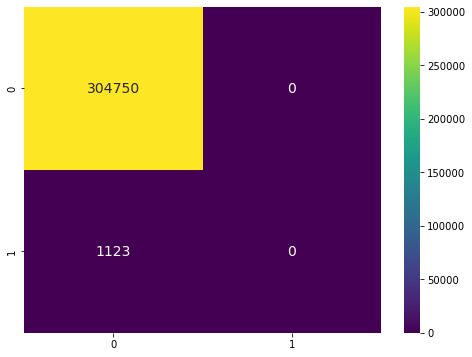

In [21]:
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cfs_matrix, cmap='viridis', annot=True, fmt='d', annot_kws=dict(fontsize=14))

In [22]:
print(classification_report(y_test, y_pred))

E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    304750
           1       0.00      0.00      0.00      1123

    accuracy                           1.00    305873
   macro avg       0.50      0.50      0.50    305873
weighted avg       0.99      1.00      0.99    305873



E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Synthetic Minority Oversampling Technique (SMOTE)

Imbalanced classes pose a significant challenge for machine learning techniques as they would ignore and hence have poor performance on the minority class when performance on the minority class is the most significant metric. An approach for dealing with such class imbalace is to oversample the minority class. Synthetic Minority Oversampling Technique (SMOTE) is one such technique where new records can be synthesized from existing records.

In [23]:
smote = SMOTE(sampling_strategy={1:1218999}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Original dataset shape %s" % Counter(y_train))
print("Resampled dataset shape %s" % Counter(y_train_smote))

Original dataset shape Counter({0: 1218999, 1: 4490})
Resampled dataset shape Counter({0: 1218999, 1: 1218999})


In [24]:
bst_smote = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
bst_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = bst.predict(X_test)

E:\anaconda_installer\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

E:\anaconda_installer\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[20:11:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


=====================SMOTE=====================


<AxesSubplot:>

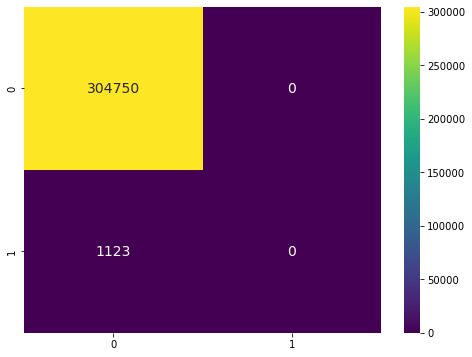

In [25]:
print("=====================SMOTE=====================")
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cfs_matrix, cmap='viridis', annot=True, fmt='d', annot_kws=dict(fontsize=14))

In [26]:
print("=====================SMOTE=====================")
print(classification_report(y_test, y_pred_smote))

=====================SMOTE=====================


E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    304750
           1       0.00      0.00      0.00      1123

    accuracy                           1.00    305873
   macro avg       0.50      0.50      0.50    305873
weighted avg       0.99      1.00      0.99    305873



E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

E:\anaconda_installer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

